# HW 5

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsteamedbun/AIPI590/blob/main/HW5/hw5.ipynb)

## Prepare model

In [ ]:
# Install the necessary libraries
!pip install torch torchvision
!pip install lime
!pip install matplotlib
!curl -O https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet34_Weights

In [4]:
# I use ResNet as the example
model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

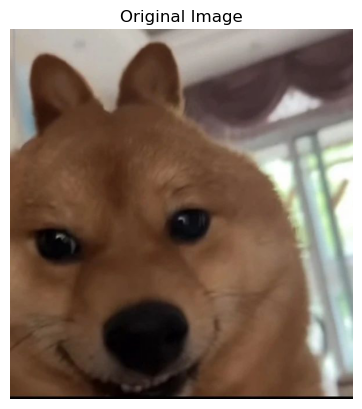

In [5]:
# Take a look
img = mpimg.imread('Rabbit_Dog.JPG')
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [6]:
preprocess = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]    
    )
])

img_t = preprocess(img)
input_tensor = img_t.unsqueeze(0)  # Add batch dimension

In [7]:
with torch.no_grad():
    output = model(input_tensor)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

top5_prob, top5_catid = torch.topk(probabilities, 5)
print("Top 5 Predictions:")
for i in range(top5_prob.size(0)):
    print(f"{labels[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")
print()
print("Got you ResNet! It's actually Shiba Inu :P")

Top 5 Predictions:
Pembroke: 32.62%
dingo: 13.34%
Chihuahua: 12.15%
basenji: 9.50%
Eskimo dog: 4.57%

Got you ResNet! It's actually Shiba Inu :P


In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)

background_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=50, shuffle=True)
background_data, _ = next(iter(background_loader))

Files already downloaded and verified



## LIME  

I chose LIME to explain the predictions of the ResNet34 model because it offers interpretable, local explanations for individual predictions of any black-box machine learning model.

Strengths
 - Model-Agnostic: Works with any machine learning model without needing internal access.
 - Local Interpretability: Provides explanations specific to individual predictions.
 - Visual Explanations: Highlights important image regions (superpixels) contributing to the prediction.
 - Flexibility: Applicable to various data types like images, text, and tabular data.

Limitations
 - Stability Issues: Explanations can vary due to randomness in sampling and segmentation.
 - Segmentation Dependence: Quality of explanations relies on the chosen segmentation algorithm.
 - Kernel Width Sensitivity: Defining the neighborhood around the instance is challenging; no robust method exists for selecting the best kernel width.
 - Computational Cost: Increasing the number of samples for better explanations can be resource-intensive.

Potential Improvements
 - Set Random Seed: Use a fixed random seed to enhance reproducibility of explanations.
 - Optimize Segmentation: Experiment with different segmentation algorithms or parameters to improve superpixel quality.
 - Adjust Kernel Width: Fine-tune the kernel width to better define the neighborhood around the instance.
 - Increase Samples: Raise num_samples to improve explanation stability, balancing computation time.
 - Combine Methods: Integrate LIME with other techniques like Grad-CAM for more comprehensive insights.


In [11]:
def predict(images):
    batch = torch.stack([preprocess(img) for img in images], dim=0).to(device)
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1)
    return probs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img),
    predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

top_class = top5_catid[0].item()

  0%|          | 0/1000 [00:00<?, ?it/s]

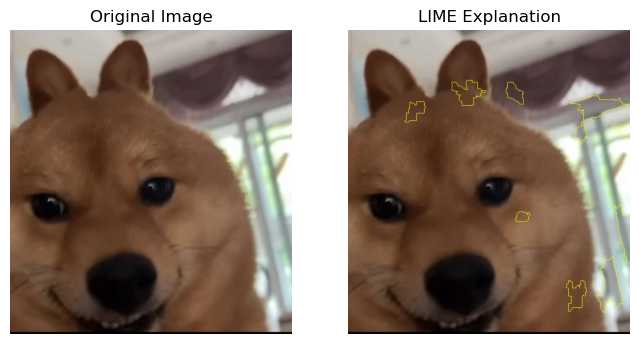

In [10]:
temp, mask = explanation.get_image_and_mask(
    label=top_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()